# Final Prject

**PHYS 242**

*Grigory Babikyan*

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings 
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from tqdm import tqdm
warnings.filterwarnings('ignore')

Problem B1: Old VEGAS

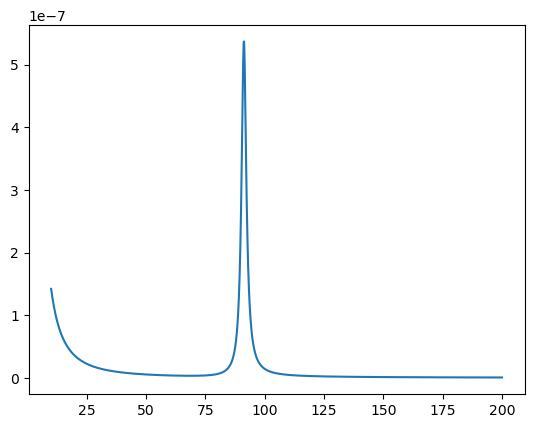

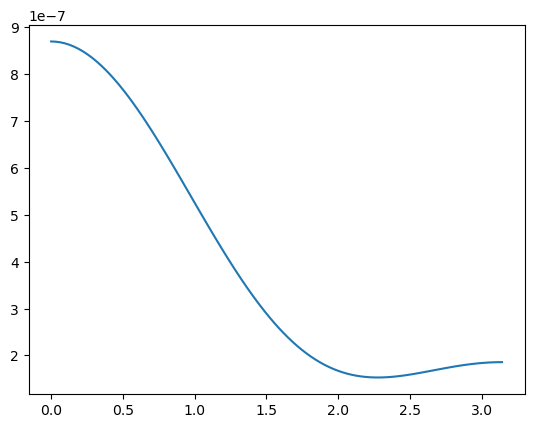

In [3]:
#define all constants and the integrand
def khi_1(s):
    G_f = 1.16639 * 1e-5
    M_z = 91.188
    Gamma_z = 2.4414
    alpha = 1/132.507
    k = np.sqrt(2)* G_f * M_z**2 / (4*np.pi*alpha)
    return k*s*(s - M_z**2)/((s - M_z**2)**2 + Gamma_z**2*M_z**2)

def khi_2(s):
    G_f = 1.16639 * 1e-5
    M_z = 91.188
    Gamma_z = 2.4414
    alpha = 1/132.507
    k = np.sqrt(2)* G_f * M_z**2 / (4*np.pi*alpha)
    return k**2*s**2 /((s - M_z**2)**2 + Gamma_z**2*M_z**2)
    
def A0(s):
    weinberg_angle = 0.222246
    Q_e = -1
    V_e = -1/2 + weinberg_angle
    V_mu = V_e
    A_e = -1/2
    A_mu = A_e
    return Q_e**2 - 2*Q_e*V_mu*V_e*khi_1(s) + (A_mu**2+V_mu**2)*(A_e**2+V_e**2)*khi_2(s)

def A1(s):
    weinberg_angle = 0.222246
    Q_e = -1
    V_e = -1/2 + weinberg_angle
    V_mu = V_e
    A_e = -1/2
    A_mu = A_e
    return -4*Q_e*A_mu*A_e*khi_1(s) + 8* A_mu*V_mu*A_e*V_e*khi_2(s)
    
def f(E, cos_theta):
    s = E**2
    alpha = 1/132.507
    cos_theta = np.cos(cos_theta)
    return (alpha**2/(4*s))*(A0(s)*(1+cos_theta**2)+A1(s)*cos_theta)
E = np.linspace(10, 200, 1901)
plt.plot(E, f(E, np.pi/2))
plt.show()
theta = np.linspace(0, np.pi, 100)
plt.plot(theta, f(90, theta))
plt.show()

Note, at this step I have already integrated over $\phi$, which was straightforward to do due to azimuthal symmetry of the integral. Therefore, we only need to integrate over $\theta$.

In [4]:
def setup_intervals(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, E_c =10, seed=None):
    """
    Input:
        NN: Number of intervals
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals 
    """
    K = 1000#default value for K
    # intitial intervals: uniform intervals between theta = 0 and pi
    thetaLow = np.linspace(0, np.pi, NN+1)
    del_theta = np.ones(NN) * (np.pi) / NN
    generator = np.random.RandomState(seed=seed)
    I = np.array([])
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = thetaLow[ixLow] + del_theta[ixLow] * generator.uniform(size=KK)
        ff = f(E_c, xx)
        fbarx = np.array(
                [sum(np.abs(ff[ixLow == i])) for i in range(NN)]##compute fbarx
            )
        I_i = np.dot(np.array([np.mean(ff[ixLow == i]) for i in range(NN)]), del_theta)#compute the integral for the i-th iteration
        I = np.append(I, I_i) #record the value of the i-th integral
        m1 = (fbarx*del_theta)/np.dot(fbarx, del_theta)
        m2 = np.log(fbarx*del_theta/np.dot(fbarx, del_theta))#just some dummy variables to help it be more readable.
        m = K*np.power((m1 - 1)/(m2), alpha_damp) #definition of m
        m = m.astype(int)#make sure m is an integer
        sub_theta = np.array([])
        for i in range(NN):
            sub_theta = np.append(sub_theta, np.linspace(thetaLow[i], thetaLow[i+1], m[i] + 1))
        n = int(len(sub_theta)/(NN))
        dn = len(sub_theta) - n*NN
        # print(dn)
        j = 0
        for i in range(NN):
            thetaLow[i] = sub_theta[j]
            if i<dn-1:
                j += n+1 # the number of bins should be approximately equal in each interval, so we devide the leftover bins
                #equally between the intervals. (1 bin is not going to affect the distribution, as the incrimental increase in the 
            #interval size will be negligible. )
            else:
                j += n
        for i in range(NN):
            del_theta[i] = thetaLow[i+1] - thetaLow[i]
    return thetaLow, del_theta, m, I#I return the m-values to see how much did the algorythm converge after nIterations.

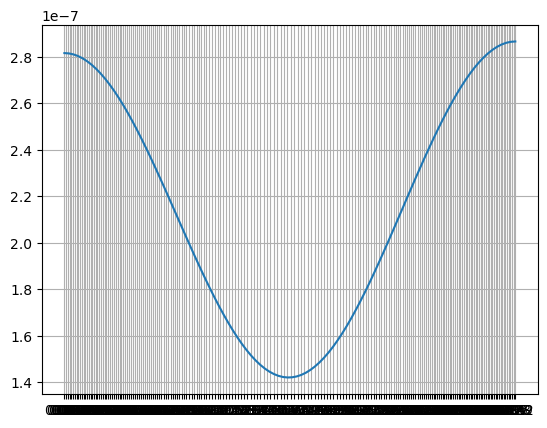

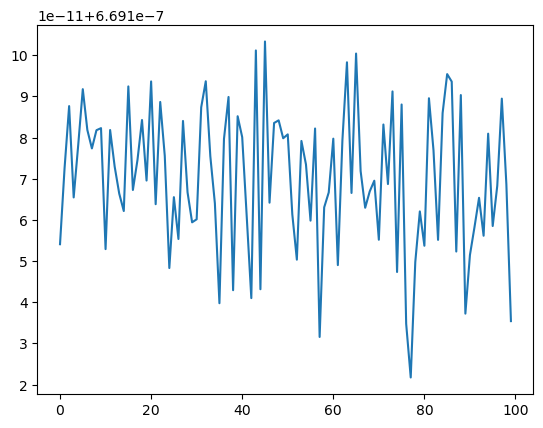

[80 81 78 80 84 82 82 78 80 82 76 80 80 84 78 84 82 77 84 83 81 74 81 85
 78 80 84 77 75 78 84 81 82 80 80 81 82 86 87 84 76 82 82 85 85 77 80 75
 90 83 83 82 83 83 80 78 83 79 77 83 84 83 85 82 78 86 78 87 83 83 85 80
 83 84 81 83 82 77 79 81 84 82 85 80 83 80 83 81 82 79 80 80 81 87 82 86
 74 75 81 84 78 79 83 82 79 79 84 86 80 79 81 80 82 77 81 84 76 81 85 82
 83 80 79 80 80 81 77 85 76 83 82 76 85 80 77 87 80 78 83 81 80 83 84 82
 77 82 88 77 80 75 80 80 82 81 81 77 77 81 76 69 86 75 76 90 78 77 76 83
 82 78 82 76 78 79 77 79 86 79 84 77 78 80 79 78 84 78 79 77 78 80 71 83
 80 79 79 82 80 81 82 83]
200


In [34]:
theta_low, del_theta, m, I = setup_intervals(NN=200, KK=10000, nIterations=100, alpha_damp=1.5, E_c =10, seed=0)
x = np.linspace(0, np.pi, 100)
fig, ax = plt.subplots()
E_c = 10
ax.plot(x, f(E_c, x))
ax.set_xticks(theta_low)
ax.grid(True)
plt.show()
plt.plot(np.arange(0, 100, 1),I)
plt.show()
print(m)
print(len(m))

Above, we can see grid lines. 

Now, let's run VEGAS for this optimized bins.

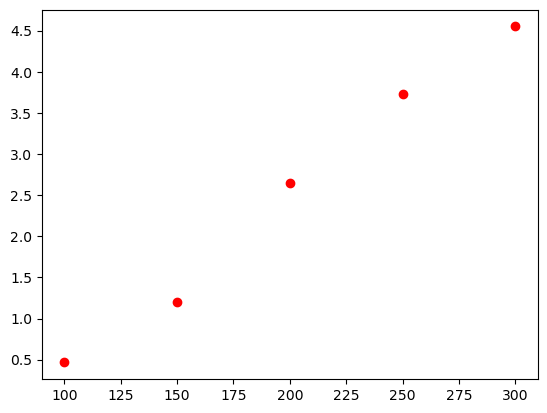

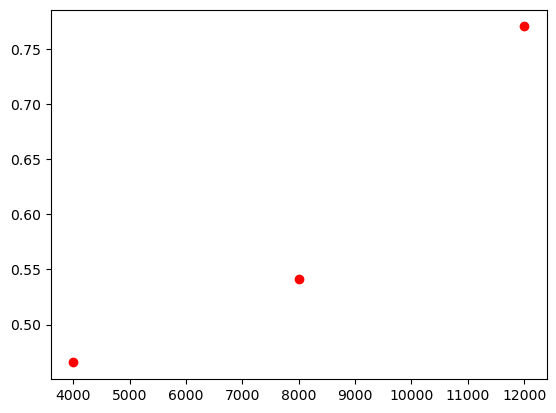

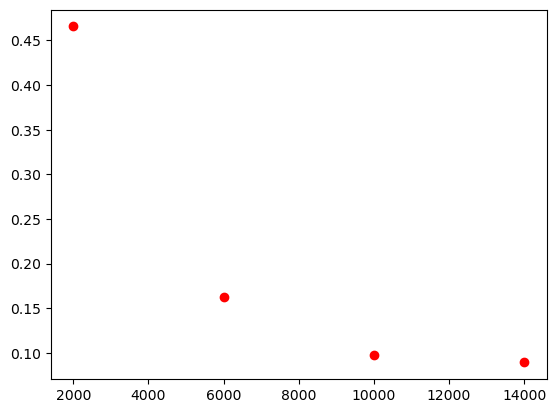

In [6]:
#looking for optimal parameters by looking at convergence of the algorythm
# first, let's check the dependence on the number of intervals:
min_sigma_m = 1000
sigma_m = []
for i in range(100, 400, 50):
    theta_low, del_theta, m, I = setup_intervals(NN=i, KK=2000, nIterations=4000, alpha_damp=1.5, E_c =10, seed=0)
    sigma_m.append(np.dot((m - np.average(m))/m, (m - np.average(m))/m))
plt.plot(np.arange(100, 400, 50), sigma_m, 'ro')
plt.show()
sigma_m = []
for i in range(4000, 16000, 4000):
    theta_low, del_theta, m, I = setup_intervals(NN=100, KK=2000, nIterations=i, alpha_damp=1.5, E_c =10, seed=0)
    sigma_m.append(np.dot((m - np.average(m))/m, (m - np.average(m))/m))
plt.plot(np.arange(4000, 16000, 4000), sigma_m, 'ro')
plt.show()
sigma_m = []
for i in range(2000, 16000, 4000):
    theta_low, del_theta, m, I = setup_intervals(NN=100, KK=i, nIterations=4000, alpha_damp=1.5, E_c =10, seed=0)
    sigma_m.append(np.dot((m - np.average(m))/m, (m - np.average(m))/m))
plt.plot(np.arange(2000, 16000, 4000), sigma_m, 'ro')
plt.show()


[2.81484857e-07 2.81345261e-07 2.80915099e-07 2.80536545e-07
 2.79723922e-07 2.78828366e-07 2.77949389e-07 2.76977067e-07
 2.75945716e-07 2.74371861e-07 2.72557672e-07 2.70866304e-07
 2.68382016e-07 2.66490187e-07 2.64183605e-07 2.62073061e-07
 2.58936303e-07 2.56888141e-07 2.54177091e-07 2.50814876e-07
 2.48218955e-07 2.44414193e-07 2.42066971e-07 2.37767651e-07
 2.33765444e-07 2.29854273e-07 2.25956475e-07 2.22450445e-07
 2.18235623e-07 2.12816818e-07 2.09086037e-07 2.03298160e-07
 1.99465295e-07 1.94345382e-07 1.90269653e-07 1.85783876e-07
 1.81690467e-07 1.78129268e-07 1.71775194e-07 1.67979560e-07
 1.63451774e-07 1.58411383e-07 1.56166547e-07 1.52276594e-07
 1.49667740e-07 1.47452618e-07 1.44684663e-07 1.43475896e-07
 1.42393560e-07 1.42029929e-07 1.42692117e-07 1.43180038e-07
 1.44950058e-07 1.47006074e-07 1.49957770e-07 1.51681114e-07
 1.56752732e-07 1.59128108e-07 1.63285704e-07 1.66692677e-07
 1.72905559e-07 1.77201815e-07 1.82118093e-07 1.85729176e-07
 1.92326937e-07 1.982145

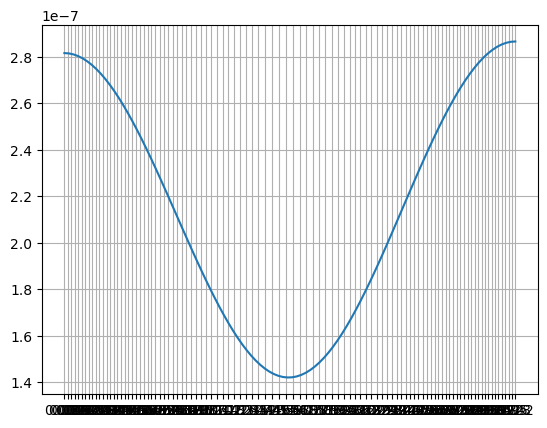

In [7]:
#compute integral:
#to compute the integral we will generate 1000 points within each bin, and compute the overall integral
#by summing over the integrals over each bin
size = 380
generator = np.random.RandomState(seed=0)
ixLow = generator.randint(0, 100, size=size)
xx = theta_low[ixLow] + del_theta[ixLow] * generator.uniform(size=size)
ff = f(E_c, xx)
print(np.array([np.mean(ff[ixLow == i]) for i in range(100)]))
print(del_theta)
I_i = np.dot(np.array([np.mean(ff[ixLow == i]) for i in range(100)]), del_theta)#compute the integral for the i-th iteration
fig, ax = plt.subplots()
E_c = 10
ax.plot(x, f(E_c, x))
ax.set_xticks(theta_low)
ax.grid(True)
plt.show()


100%|██████████| 21/21 [02:25<00:00,  6.92s/it]


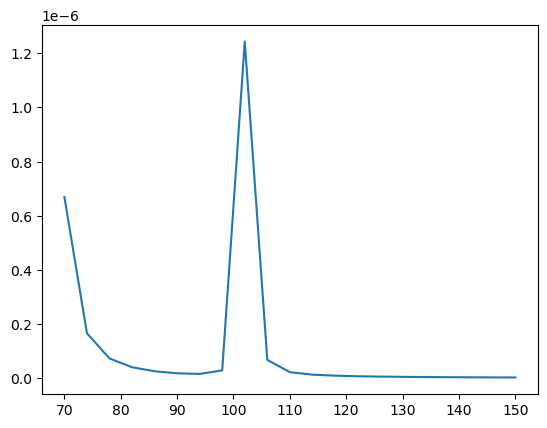

In [8]:
def cross_section(E_c):
    theta_low, del_theta, m, I = setup_intervals(NN=100, KK=16000, nIterations=1000, alpha_damp=1.5, E_c = E_c, seed=0)
    return I[-1]
I = np.array([])
for i in tqdm(range(21)):
    I = np.append(I, cross_section(i*10+10))
plt.plot(np.linspace(70, 150, 21), I)
plt.show()

Above, we computed $\sigma$. Now, let's try to generate sample's for the functional above.


In [19]:
XMIN = 10
XMAX = 200
YMIN = 0
YMAX = np.pi
F_VAL_MAX = np.max(f(np.linspace(XMIN, XMAX, 1000), np.linspace(YMIN, YMAX, 1000))) 

def setup_intervals_new(NN=100, KK=2000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    xLow = XMIN + (XMAX - XMIN) / NN * np.arange(NN + 1)
    delx = np.ones(NN) * (XMAX - XMIN) / NN
    px = np.ones(NN) / (XMAX - XMIN)  # probability density in each interval
    yLow = YMIN + YMAX / NN * np.arange(NN + 1)
    dely = np.ones(NN) * (YMAX - YMIN) / NN
    py = np.ones(NN) / (YMAX - YMIN)

    generator = np.random.RandomState(seed=seed)
    for _ in tqdm(range(nIterations)):
        ixLow = generator.randint(0, NN, size=KK)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = f(xx, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum
        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)
        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]
        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely


def vegas(
    nPoints,
    vegasRatioFactor,
    NN=200,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=0,
):
    xLow, yLow, delx, dely = setup_intervals_new(NN, KK, nIterations, alpha_damp, seed)
    print('intervals are set')
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform()
        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = f(xx, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]
        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
        if ratio > vegasRatioMax:
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

In [20]:
vg = vegas(1_000_000, 0.1)

100%|██████████| 4000/4000 [00:29<00:00, 134.52it/s]


intervals are set


In [21]:
Theta = vg["yy2vegas"]
E = vg["yy1vegas"]
print(len(Theta))
print(len(E))

1000000
1000000


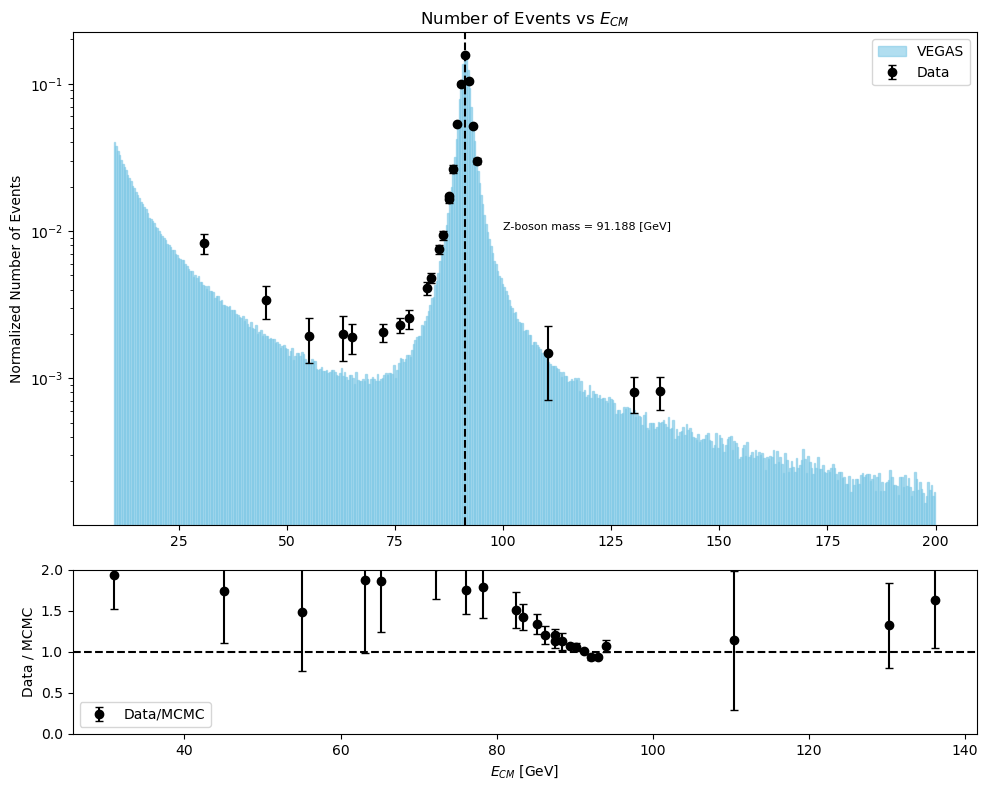

In [38]:
# Data from ALEPH
data_energy = np.array([63.12, 72.18, 78.29, 82.5, 85.2, 87.49, 88.37, 89.42, 90.21, 91.23, 92.05, 92.99, 94.03, 110.46, 130.2, 136.21,
                        30.94, 45.11, 55.12, 65.15, 76.08, 83.37, 86.13, 87.53]) 
data_cs = np.array([0.0253, 0.0263, 0.0325, 0.052, 0.0956, 0.219, 0.336, 0.6759, 1.276, 2.0018, 1.322, 0.657, 0.381, 0.019, 0.0102, 0.0104,
                    0.105, 0.043, 0.0245, 0.0243, 0.0291, 0.061, 0.1191, 0.21]) 
data_cs_error_plus = np.array([0.0085, 0.0037, 0.0048, 0.0053, 0.0061, 0.01, 0.022, 0.0075, 0.044, 0.006, 0.04, 0.0068, 0.018, 0.01, 0.0028, 0.0026,
                               0.016, 0.011, 0.0084, 0.0057, 0.0034, 0.0048, 0.0076, 0.011])
data_cs_error_minus = np.array([0.0085, 0.0037, 0.0048, 0.0053, 0.0061, 0.01, 0.022, 0.0075, 0.044, 0.006, 0.04, 0.0068, 0.018, 0.01, 0.0028, 0.0026,
                                0.016, 0.011, 0.0084, 0.0057, 0.0034, 0.0048, 0.0076, 0.011]) 

#counts and bins
counts, bins = np.histogram(E, bins=500, density=True)
fig = plt.figure(figsize=(10, 8))

# gridspec 
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0])

#plot the mcmc
ax1.hist(E, bins=500, color='#7EC8E6', edgecolor='#7EC8E6', density=True, alpha=0.6, label="VEGAS")

# scale the data to MCMC (weights)
max_hist = max(counts)
max_cross_section = max(data_cs)
scaled_cross_section = (data_cs / max_cross_section) * max_hist
scaled_error_plus = (data_cs_error_plus / max_cross_section) * max_hist
scaled_error_minus = (data_cs_error_minus / max_cross_section) * max_hist

# plot the data
ax1.errorbar(data_energy, scaled_cross_section, yerr=[scaled_error_minus, scaled_error_plus], fmt='o', color='black', label="Data", capsize=3)
ax1.axvline(x=91.188, color='black', linestyle='--')
ax1.text(100, 0.01, "Z-boson mass = 91.188 [GeV]", color='black', fontsize=8, verticalalignment='bottom')
#ax1.set_xlabel("$E_{CM}$ [GeV]")
ax1.set_ylabel("Normalized Number of Events")
ax1.set_title("Number of Events vs $E_{CM}$")
ax1.set_yscale('log')
ax1.legend()

# data over MCMC plot
ax2 = fig.add_subplot(gs[1])

# ratio
ratio = scaled_cross_section / np.interp(data_energy, (bins[:-1] + bins[1:]) / 2, counts)

# Calculate error bars for the ratio
ratio_error = ratio * np.sqrt((scaled_error_plus / scaled_cross_section)**2 + (scaled_error_minus / scaled_cross_section)**2)

# plot the ratio
ax2.errorbar(data_energy, ratio, yerr=ratio_error, fmt='o', color='black', capsize=3, label="Data/MCMC")
ax2.axhline(y=1, color='black', linestyle='--') 
ax2.set_xlabel("$E_{CM}$ [GeV]")

ax2.set_ylabel("Data / MCMC")
ax2.set_ylim(0, 2) 
ax2.legend()

plt.tight_layout()
plt.savefig("Final Graph.png")
plt.show()

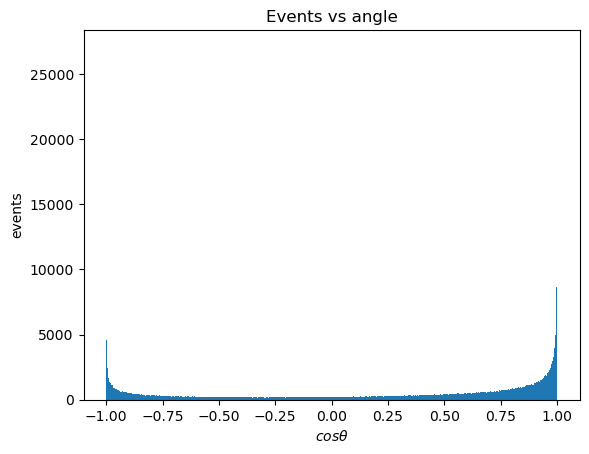

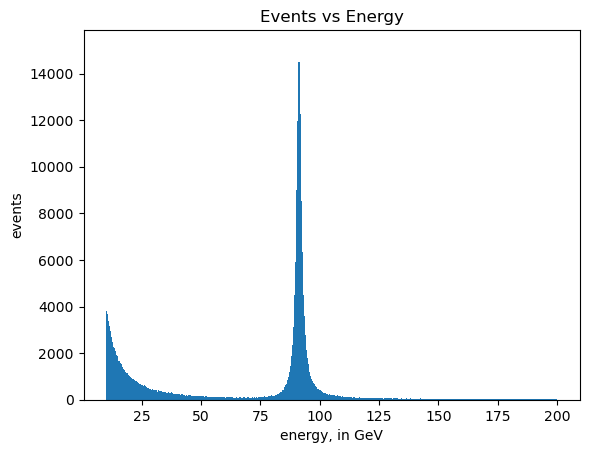

In [23]:
plt.hist(np.cos(Theta), bins = 2000)
plt.title("Events vs angle")
plt.xlabel("$cos \\theta$")
plt.ylabel("events")
plt.savefig("Angle dependence")
plt.show()
E0 = plt.hist(E, bins = 2000)
plt.title("Events vs Energy")
plt.xlabel("energy, in GeV")
plt.ylabel("events")
plt.savefig("energy dependence")
plt.show()

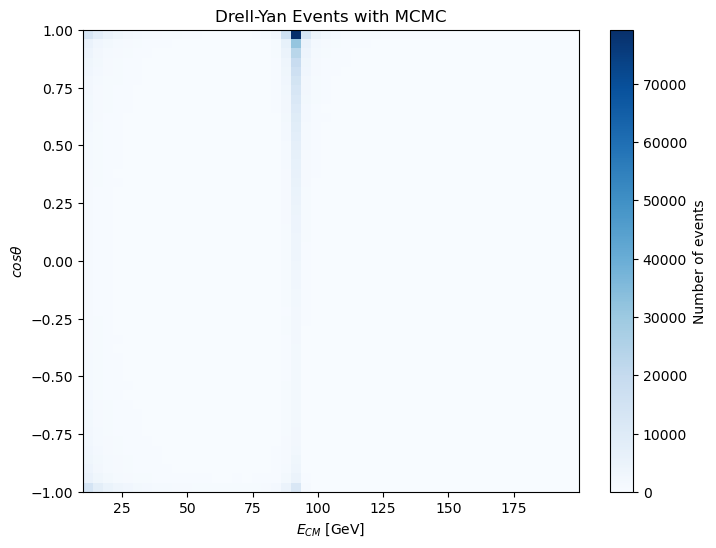

In [24]:
plt.figure(figsize=(8,6))
plt.hist2d(E, np.cos(Theta), bins=50, cmap='Blues')
plt.colorbar(label="Number of events")
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("$cos \\theta$")
plt.title("Drell-Yan Events with MCMC")
plt.savefig("HeatMap")
plt.show()

In [25]:
sigma, E1, container= E0
print(E1)

[ 10.00002611  10.09502131  10.19001651 ... 199.80042889 199.89542409
 199.99041928]


In [26]:
E1 = E1[:-1]

[6.27937163e+02 1.50138620e+02 9.12008331e+01 1.34218607e-02]


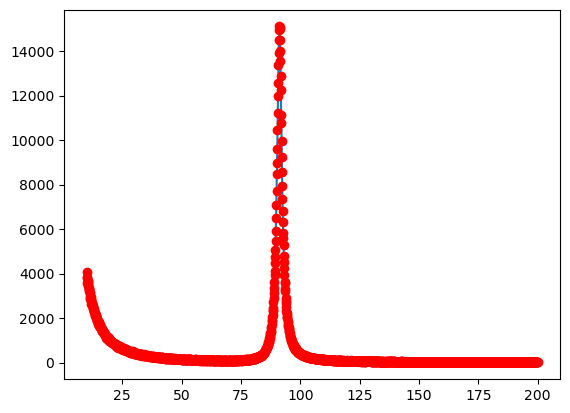

In [27]:
def cross_section(E, z1, z2, M, Gamma):
    return z1**2/((E**2)) + z2**2/((E - M)**2 + (M*Gamma)**2)
popt, pcov = curve_fit(cross_section, E1, sigma, p0 = (500_000, 500_000, 90, 10), bounds = (0, [np.inf, np.inf, 100, 20]))
print(popt)
x = np.linspace(np.min(E1), np.max(E1), 1001)
plt.plot(x, cross_section(x, *popt))
plt.plot(E1, sigma, 'ro')
plt.show()

In [28]:
#now, recognize that Gamma is particle's decay width. We can recover it's lifetime by t = h_bar/Gamma
#convert gamma from GeV to eV:
Gamma = popt[-1]*1e9
t = 6.582e-16/Gamma
print("lifetime of z-boson: ",t, " s")

lifetime of z-boson:  4.903940035669491e-23  s
